In [118]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pprint import pprint
from tqdm import tqdm
from functools import reduce

In [119]:
import os
import sys
sys.path.append(os.path.abspath(os.path.join('..', 'src')))

In [120]:
from utils.geometrics import haversine_distance

In [121]:
from sklearn.cluster import KMeans, DBSCAN, AffinityPropagation, AgglomerativeClustering
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline

# weather features

In [122]:
df_weather = pd.read_parquet('../data/01_raw/weather.parquet')

In [123]:
df_weather_by_day = (
    df_weather
    .eval('date = date.dt.date.astype("datetime64[ns]")')
    .groupby('date')
    .agg(
        temperature_2m_min=('temperature_2m', 'min'),
        temperature_2m_max=('temperature_2m', 'max'),
        temperature_2m=('temperature_2m', 'mean'),
        apparent_temperature=('apparent_temperature', 'mean'),
        precipitation=('precipitation', 'sum'),
        cloud_cover=('cloud_cover', 'sum'),
        dew_point_2m=('dew_point_2m', 'mean'),
        snow_depth=('snow_depth', 'max'),
        wind_speed_10m=('wind_speed_10m', 'mean'),
        wind_speed_100m=('wind_speed_100m', 'mean'),
        pressure_msl=('pressure_msl', 'mean'),
        relative_humidity_2m=('relative_humidity_2m', 'mean'),
        rainfall=('precipitation', 'sum'),
    )
    .reset_index()
)

In [124]:
df_weather_by_day.to_parquet('../data/02_intermediate/weather_by_day.parquet', index=False)

# Loading bike data

In [125]:
df_bike = pd.read_parquet('../data/01_raw/bike.parquet')
df_bike.head()

,trip_duration,start_time,stop_time,start_station_id,start_station_name,start_station_latitude,start_station_longitude,end_station_id,end_station_name,end_station_latitude,end_station_longitude,bike_id,user_type,birth_year,gender,trip_duration_in_min
0,376,2015-10-01 00:16:26,2015-10-01 00:22:42,3212,'Christ Hospital',40.734786,-74.050444,3207,'Oakland Ave',40.737604,-74.052478,24470,Subscriber,1960.0,1,6
1,739,2015-10-01 00:27:12,2015-10-01 00:39:32,3207,'Oakland Ave',40.737604,-74.052478,3212,'Christ Hospital',40.734786,-74.050444,24481,Subscriber,1960.0,1,12
2,2714,2015-10-01 00:32:46,2015-10-01 01:18:01,3193,'Lincoln Park',40.724605,-74.078406,3193,'Lincoln Park',40.724605,-74.078406,24628,Subscriber,1983.0,1,45
3,275,2015-10-01 00:34:31,2015-10-01 00:39:06,3199,'Newport Pkwy',40.728745,-74.032108,3187,'Warren St',40.721124,-74.038051,24613,Subscriber,1975.0,1,5
4,561,2015-10-01 00:40:12,2015-10-01 00:49:33,3183,'Exchange Place',40.716247,-74.033459,3192,'Liberty Light Rail',40.711242,-74.055701,24668,Customer,1984.0,0,9


In [126]:
start_station = (
    df_bike[['start_station_id','start_station_name', 'start_station_latitude','start_station_longitude']]
    .drop_duplicates()
    .rename(columns=lambda x:x.replace('start_station_',''))
)

end_station = (
    df_bike[['end_station_id', 'end_station_name', 'end_station_latitude', 'end_station_longitude']]
    .drop_duplicates()
    .rename(columns=lambda x:x.replace('end_station_','').lower())
)

stations = pd.concat([start_station, end_station]).drop_duplicates().sort_values('id')

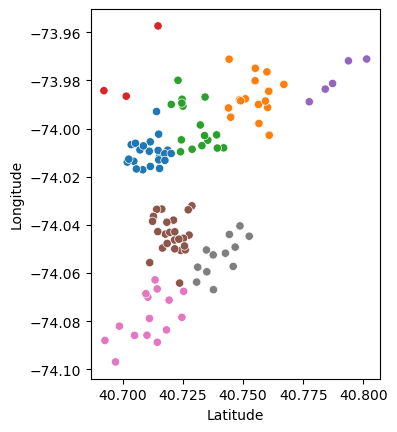

In [127]:
# creating tiles based on clusters of lat/lon
cluster = Pipeline([
    ('scaler', StandardScaler()),
    ('cluster', AffinityPropagation())
])
stations['tile'] = cluster.fit_predict(stations[['latitude', 'longitude']]).astype(str)

sns.scatterplot(data=stations.query('longitude != 0'),y='longitude', x='latitude', hue='tile')
plt.xlabel('Latitude')
plt.ylabel('Longitude')
plt.gca().set_aspect('equal', adjustable='box')
plt.legend().set_visible(False)

In [128]:
tiles = (
    stations
    .groupby('tile')
    .agg(
        latitude_tile=('latitude', 'mean'),
        longitude_tile=('longitude', 'mean'),
    )
    .reset_index()
)

In [129]:
stations = (
    stations
    .merge(tiles,on='tile')
    .assign(
        distance_to_tile_center=lambda x: haversine_distance(
            x['latitude'], x['longitude'],
            x['latitude_tile'], x['longitude_tile']
        )
    )
)

In [130]:
stations.to_parquet('../data/02_intermediate/stations.parquet', index=False)
stations.head()

,id,name,latitude,longitude,tile,latitude_tile,longitude_tile,distance_to_tile_center
0,147,'Greenwich St Warren St',40.715422,-74.011220,1,40.711147,-74.010095,0.484747
1,152,'Warren St Church St',40.714740,-74.009106,1,40.711147,-74.010095,0.408147
2,173,'Broadway W 49 St',40.760683,-73.984527,3,40.754539,-73.986911,0.712126
3,224,'Spruce St Nassau St',40.711464,-74.005524,1,40.711147,-74.010095,0.386863
4,225,'W 14 St The High Line',40.741951,-74.008030,0,40.730239,-73.998749,1.519095


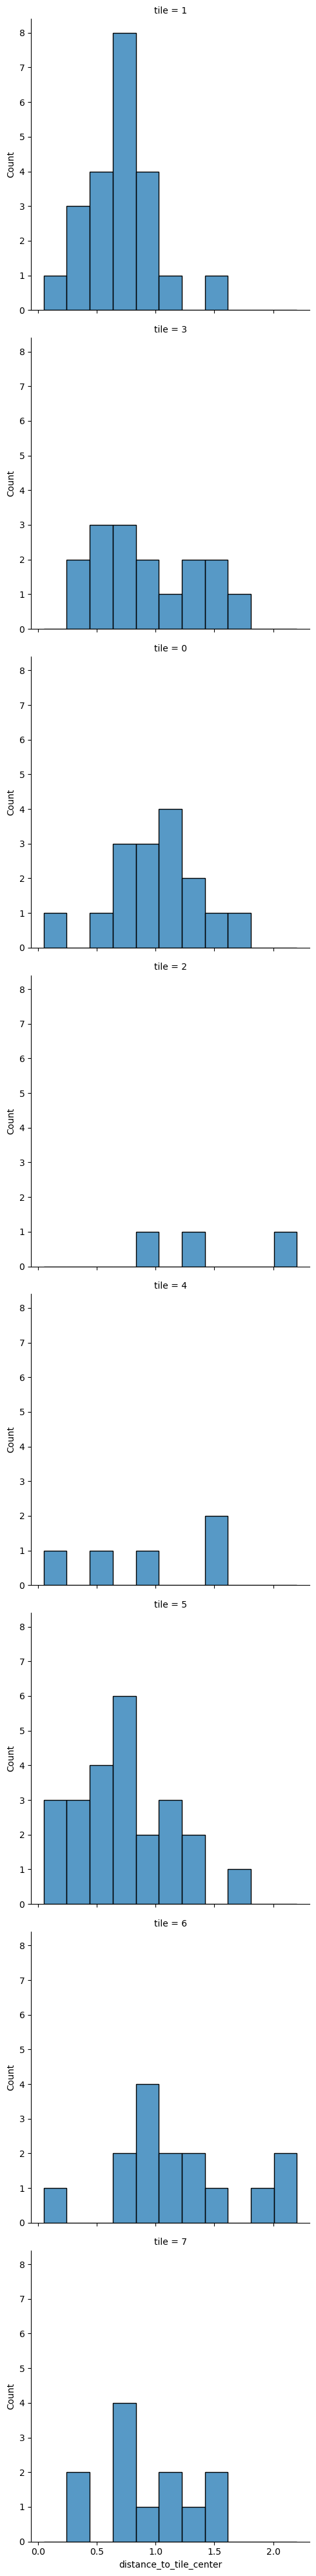

In [131]:
sns.displot(stations, x='distance_to_tile_center', row='tile');

In [132]:
def create_distance_matrix(points_id, latitudes, longitudes):
    # Calculate distance matrix using vectorized haversine_distance
    num_stations = len(stations)
    distance_matrix = np.zeros((num_stations, num_stations))

    # Expand dimensions for broadcasting
    lat1_expanded = latitudes[:, np.newaxis]
    lon1_expanded = longitudes[:, np.newaxis]
    lat2_expanded = latitudes[np.newaxis, :]
    lon2_expanded = longitudes[np.newaxis, :]

    distance_matrix = haversine_distance(lat1_expanded, lon1_expanded, lat2_expanded, lon2_expanded)

    # Convert to DataFrame for better readability and indexing
    distance_matrix_df = pd.DataFrame(distance_matrix, index=points_id, columns=points_id)
    return distance_matrix_df

distance_matrix_df= create_distance_matrix(stations['id'], stations['latitude'].values, stations['longitude'].values)

In [133]:
distance_matrix_df.to_parquet('../data/02_intermediate/distance_matrix.parquet', index=False)

In [134]:
distance_matrix_df = (
    distance_matrix_df.reset_index().melt(
        id_vars='id',
        var_name='dest',
        value_name='distance'
    )
    .rename(columns={
        'id':'start_station_id',
        'dest':'end_station_id'
    })
)

In [135]:
distance_matrix_df.to_parquet('../data/02_intermediate/distance_matrix_cols.parquet', index=False)
distance_matrix_df

,start_station_id,end_station_id,distance
0,147,147,0.000000
1,152,147,0.193602
2,173,147,5.512435
3,224,147,0.651280
4,225,147,2.962155
...,...,...,...
12764,3280,3426,1.094186
12765,3281,3426,4.143322
12766,3314,3426,12.403992
12767,3331,3426,13.089542


In [145]:
bikes_out = (
    df_bike
    .rename(columns={'start_station_id': 'station_id'})
    .eval('date_ref = start_time.dt.date')
    .groupby(['station_id', 'date_ref'])
    .agg(
        n_bikes_out=('bike_id', 'count'),
        n_distinct_bikes_out=('bike_id', 'nunique'),
    )
    .reset_index()
)

bikes_in = (
    df_bike
    .rename(columns={'end_station_id': 'station_id'})
    .eval('date_ref = stop_time.dt.date')
    .groupby(['station_id', 'date_ref'])
    .agg(
        n_bikes_in=('bike_id', 'count'),
        n_distinct_bikes_in=('bike_id', 'nunique'),
    )
    .reset_index()
)

In [161]:
df_bike_turnover = (
    bikes_out
    .merge(bikes_in, on=['station_id', 'date_ref'], how='outer')
    .fillna(0)
    .eval('turnover = (n_bikes_in - n_bikes_out) / (n_bikes_in + n_bikes_out)')
    .eval('turnover_distinct = (n_distinct_bikes_in - n_distinct_bikes_out) / (n_distinct_bikes_in + n_distinct_bikes_out)')
)
df_bike_turnover.head()

,station_id,date_ref,n_bikes_out,n_distinct_bikes_out,n_bikes_in,n_distinct_bikes_in,turnover,turnover_distinct
0,147,2016-03-30,0.0,0.0,2.0,1.0,1.0,1.0
1,152,2017-02-23,0.0,0.0,2.0,1.0,1.0,1.0
2,152,2017-02-24,0.0,0.0,2.0,1.0,1.0,1.0
3,152,2017-02-27,0.0,0.0,2.0,1.0,1.0,1.0
4,152,2017-02-28,0.0,0.0,2.0,1.0,1.0,1.0


In [162]:
df_bike_turnover.to_parquet('../data/02_intermediate/bike_turnover.parquet', index=False)